# TFIDF 
* **Training data:** data version from Manifest project (version 2018-2) with 7 English speaking countries from original paper by Osnabrügge ("Australia", "Canada", "Ireland", "New Zealand", "United Kingdom", "United States", "South Africa").  
* **Testing data:** random test split  
* implementaion based on paper "Osnabrügge, M., Ash, E., & Morelli, M. (2021). Cross-Domain Topic Classification for Political Texts. Political Analysis, 1-22. doi:10.1017/pan.2021.37" and modified slightly
* moficiations compared to paper:
    * own extracted data fom Manifesto Project database (very similar, not exactly the same)
    * change train-test split to 0.8 instead of 0.75
    * fit term-document matrix on X_train and not whole source corpus
    * changed evaluation metric to f1-macro for hyperparameter tuning because of class imbalance (instead of accuracy). However, didn't change hyperaparameters

## Load packages, functions and data

In [1]:
# Load google drive. 
# Note: Working directory might need to be changed if run on your computer.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# set wroking directory and load functions from 05_TFIDF_utils
import sys  
sys.path.insert(0, '/content/drive/MyDrive/Paper BERT/notebooks')
from TFIDF_utils import *

In [6]:
# load data
path_file = './drive/MyDrive/Paper BERT/data/multilingual_data_2018-2.csv'
data = pd.read_csv(path_file,  index_col=None)

# ensure variables as string
data['topic_8'] = data['topic_8'].astype(str) # categories
data['text'] = data['text'].astype(str) # topic


Select English speaking countries: Australia, Canada, Ireland, New Zealand, South Africa, the United Kingdom (UK) and the United States (USA) and language english (e.g. in Canada French is also official national language)

In [10]:
# select English speaking countries
countries = ["Australia", "Canada", "Ireland", "New Zealand", "United Kingdom", "United States", "South Africa"]
data_english = data.loc[data['countryname'].isin(countries), :]
data_english = data_english.loc[data_english['language'] =="english", :]
print(data_english.shape)
data_english.head(3) 
# note: BA also 114,523 observations

# X: text, Y: topic
X = data_english['text'] 
Y = data_english['topic_8']

(114523, 7)


In [11]:
Y[0:3]

512801                        economy
512802    welfare and quality of life
512803          freedom and democracy
Name: topic_8, dtype: object

In [12]:
X[0:3]

512801    We face three connected crises: Healing the pl...
512802    Creating a more equal society, reversing the t...
512803    Creating truly democratic central and local go...
Name: text, dtype: object

## Test-Train-Split

In [13]:
# create training and testing data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=.8, random_state=77)

# check dimenstion
print(X_train.shape)
print(X_test.shape)

# Reset the index 
X_test = X_test.reset_index(drop=True)
Y_test = Y_test.reset_index(drop=True)

(91618,)
(22905,)


## Create Embedding

Create embedding based on X_train

In [16]:
# Fit Embedding
start_time = time.time()

# Transform X with TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, ngram_range=(1,3), min_df=10, max_df=.4)
tfidf_vectorizer.fit(X_train)

fit_embedding_time = time.time() - start_time
print("--- %s seconds ---" % (fit_embedding_time))

--- 6.5121519565582275 seconds ---


In [17]:
# Create embedding of train and test set
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [18]:
# Check shapes 
print(X.shape)
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(114523,)
(91618, 15210)
(22905, 15210)


## Fitting model

### Dummy classifier

Baseline with Dummy classifier

In [19]:
# always predicting most common class
dummy_clf = DummyClassifier(strategy='prior')
dummy_clf.fit(X_train_tfidf, Y_train)
print(dummy_clf.score(X_train_tfidf, Y_train))

# guessing
dummy_clf = DummyClassifier(strategy='uniform', random_state =77)
dummy_clf.fit(X_train_tfidf, Y_train)
dummy_clf.score(X_train_tfidf, Y_train)

0.313366369054116


0.12707109956558754

In [20]:
# percentage most common class 'welfare and quality of life' in training data
print(sum(Y_train== 'welfare and quality of life')/len(Y_train))
# percentage most common class 'welfare and quality of life' in overall data
print(data[data['topic_8'] == 'welfare and quality of life'].shape[0]/data.shape[0])

0.313366369054116
0.2897988771174529


### Grid search

Fit Logistic regression on creted term-document matrix. Use Grid search for hyperparameter optimization.

Hyperparameter tuning of C and class_weight with GridSearchCV
* result of paper by Osnabrügge: best hyperparameter are C= 2 and class_weight = None 

In [45]:
from sklearn.metrics import f1_score, make_scorer
f1 = make_scorer(f1_score , average='macro')

##Cross-validated grid-search
lin_clf = LogisticRegression(solver='newton-cg', multi_class='multinomial', n_jobs=cpus, random_state=77)


param_grid = {'C':[1,2,10,100], 'class_weight':[None,'balanced']}
CV_clf = GridSearchCV(estimator=lin_clf, param_grid=param_grid, cv=3, scoring=f1) 
CV_clf.fit(X_train_tfidf, Y_train)
print(CV_clf.best_params_) 
print(CV_clf.best_score_) 
print(CV_clf.best_estimator_)

{'C': 1, 'class_weight': 'balanced'}
0.5105894748813521
LogisticRegression(C=1, class_weight='balanced', multi_class='multinomial',
                   n_jobs=1, random_state=77, solver='newton-cg')


**Result Grid search:**   
{'C': 1, 'class_weight': 'balanced'}  
0.5105894748813521  
LogisticRegression(C=1, class_weight='balanced',     multi_class='multinomial',  
                   n_jobs=1, random_state=77, solver='newton-cg')
  

Fit model with best hyperparameters:

In [21]:
start_time = time.time()

# fit LR with best hyperparameter of GridSearch
lin_clf = LogisticRegression(C=2, class_weight=None, solver='newton-cg', multi_class='multinomial', n_jobs=cpus) 
lin_clf.fit(X_train_tfidf, Y_train)

fit_train_time = time.time() - start_time
print("--- %s minutes ---" % (round(fit_train_time/60, 2)))

--- 0.42 minutes ---


In [22]:
# make predictions
Y_pred_train = lin_clf.predict(X_train_tfidf)
Y_prob_train =  lin_clf.predict_proba(X_train_tfidf)
classes = lin_clf.classes_ 

## Evaluation

In [28]:
path_results = './drive/MyDrive/Paper BERT/results/05_TFIDF'

### Evaluation on training data

In [23]:
evaluation_table_training = evaluation_table(Y_train, Y_pred_train, domain= 'within-domain', data_description = "training")
evaluation_table_training

,metric,score,domain,data
0,Accuracy,0.742507,within-domain,training
1,F1 score (macro),0.635382,within-domain,training


### Evaluation on test set

In [24]:
Y_pred_test = lin_clf.predict(X_test_tfidf)
Y_prob_test = lin_clf.predict_proba(X_test_tfidf)

In [25]:
evaluation_table_testing = evaluation_table(Y_test, Y_pred_test, domain= 'within-domain', data_description = "testing")
evaluation_table_testing

,metric,score,domain,data
0,Accuracy,0.641301,within-domain,testing
1,F1 score (macro),0.519510,within-domain,testing


Accuracy: 0.64
Auc: 0.88
Detail:
                             precision    recall  f1-score  support     data
economy                       0.659794  0.747038  0.700711   5740.0  testing
external relations            0.705176  0.645604  0.674077   1456.0  testing
fabric of society             0.612111  0.557331  0.583438   2503.0  testing
freedom and democracy         0.583529  0.446043  0.505607   1112.0  testing
no topic                      0.111111  0.005051  0.009662    198.0  testing
political system              0.519231  0.433277  0.472376   2368.0  testing
social groups                 0.576878  0.429821  0.492608   2287.0  testing
welfare and quality of life   0.673531  0.767850  0.717605   7241.0  testing


<Figure size 432x288 with 0 Axes>

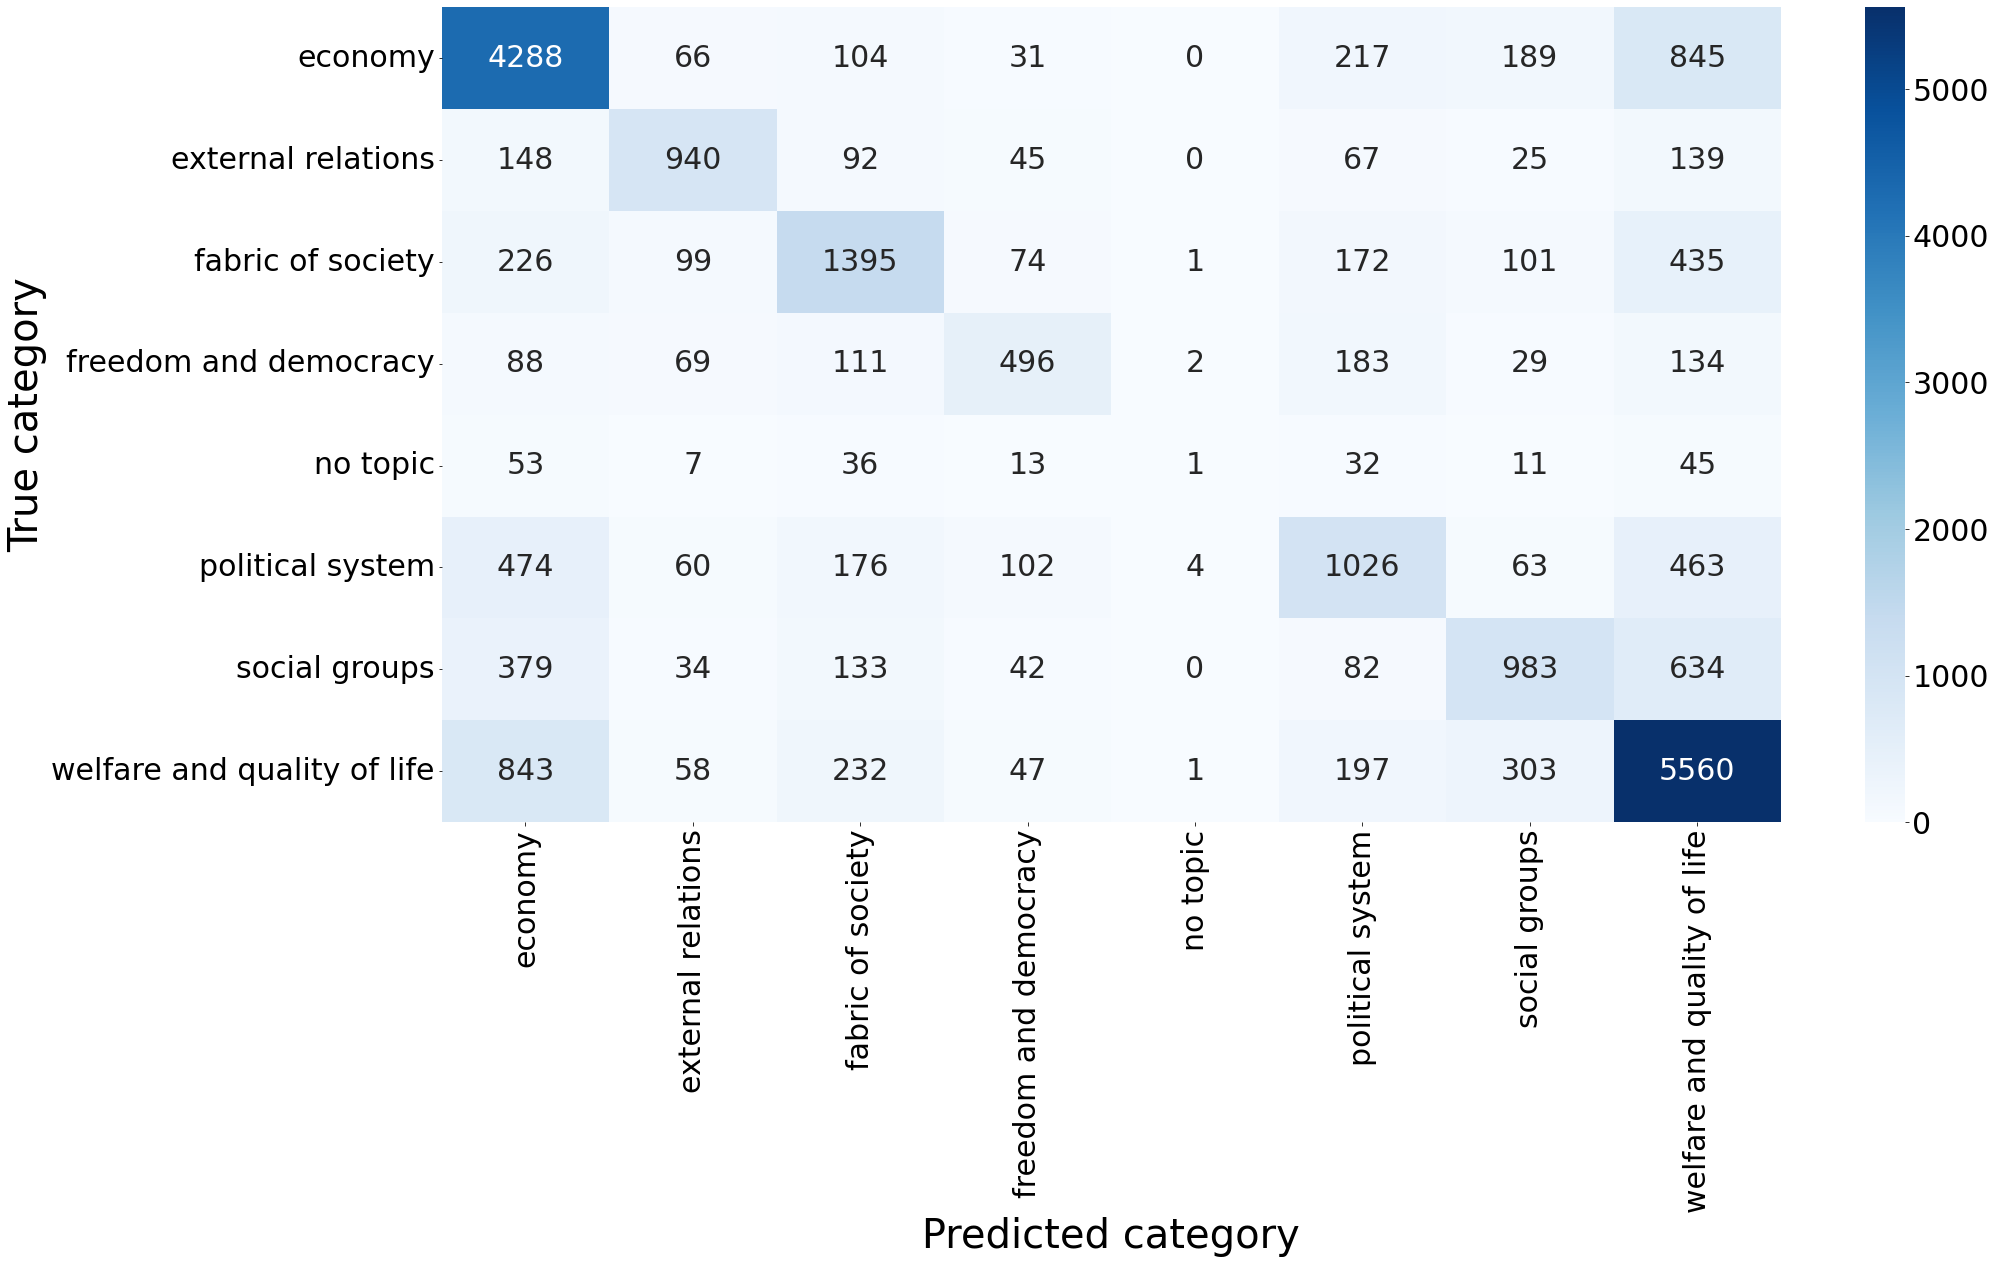

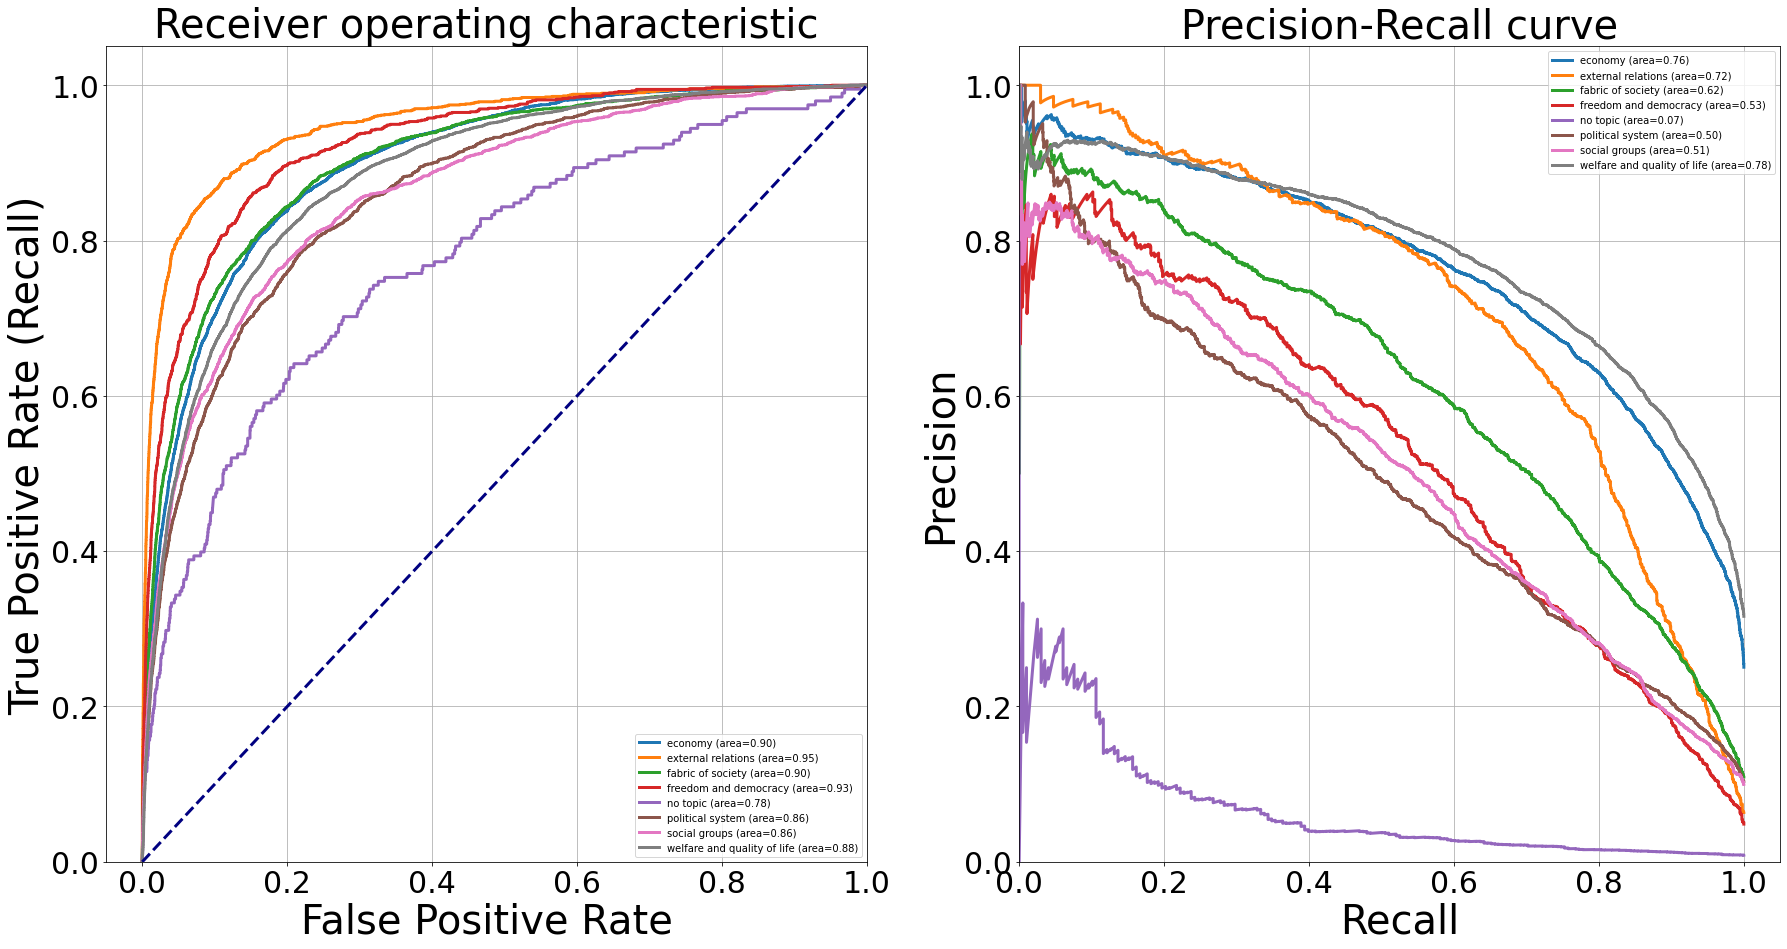

In [32]:
classification_report_testing = evaluation_per_category(Y_test, Y_pred_test,  Y_prob_test, classes, data_description = "testing", path_results= path_results)

## Cross-Domain Classification on target corpus

Load data:

In [33]:
# load data
path_file = './drive/MyDrive/Paper BERT/data/target_data.csv'
data_target = pd.read_csv(path_file,  index_col=None, sep = ';')

# ensure variables as string
data_target['topic_8'] = data_target['topic_8'].astype(str) # categories
data_target['text'] = data_target['text'].astype(str) # topic

# X: text, Y: topic
X_target = data_target['text'] 
Y_target = data_target['topic_8']

# show data
data_target.head(3)

,topic_8,text
0,welfare and quality of life,In the light of Mr Kelly's statements to the m...
1,external relations,Will New Zealand send further assistance to Fi...
2,welfare and quality of life,"There are many programmes out there, and there..."


In [34]:
X_target[0:3]

0    In the light of Mr Kelly's statements to the m...
1    Will New Zealand send further assistance to Fi...
2    There are many programmes out there, and there...
Name: text, dtype: object

In [35]:
Y_target[0:3]

0    welfare and quality of life
1             external relations
2    welfare and quality of life
Name: topic_8, dtype: object

Make predictions: 

In [36]:
start_time = time.time()
# create embedding of X 
X_tfidf_target = tfidf_vectorizer.transform(X_target)

# make predictions
Y_pred_target = lin_clf.predict(X_tfidf_target)
Y_prob_target =  lin_clf.predict_proba(X_tfidf_target)
classes = lin_clf.classes_ 

fitting_target_time = time.time() - start_time
print("--- %s seconds ---" % (fitting_target_time))

--- 1.7022974491119385 seconds ---


Evaluation:

In [37]:
evaluation_table_target = evaluation_table(Y_target, Y_pred_target, domain= 'cross-domain', data_description = "target", )
evaluation_table_target

,metric,score,domain,data
0,Accuracy,0.505882,cross-domain,target
1,F1 score (macro),0.447445,cross-domain,target


Accuracy: 0.51
Auc: 0.81
Detail:
                             precision    recall  f1-score  support    data
economy                       0.574561  0.545833  0.559829    720.0  target
external relations            0.565217  0.553191  0.559140     94.0  target
fabric of society             0.529833  0.513889  0.521739    432.0  target
freedom and democracy         0.424628  0.366972  0.393701    545.0  target
no topic                      0.000000  0.000000  0.000000    192.0  target
political system              0.454348  0.587079  0.512255   1068.0  target
social groups                 0.482014  0.412308  0.444444    325.0  target
welfare and quality of life   0.570918  0.607098  0.588452    789.0  target


<Figure size 432x288 with 0 Axes>

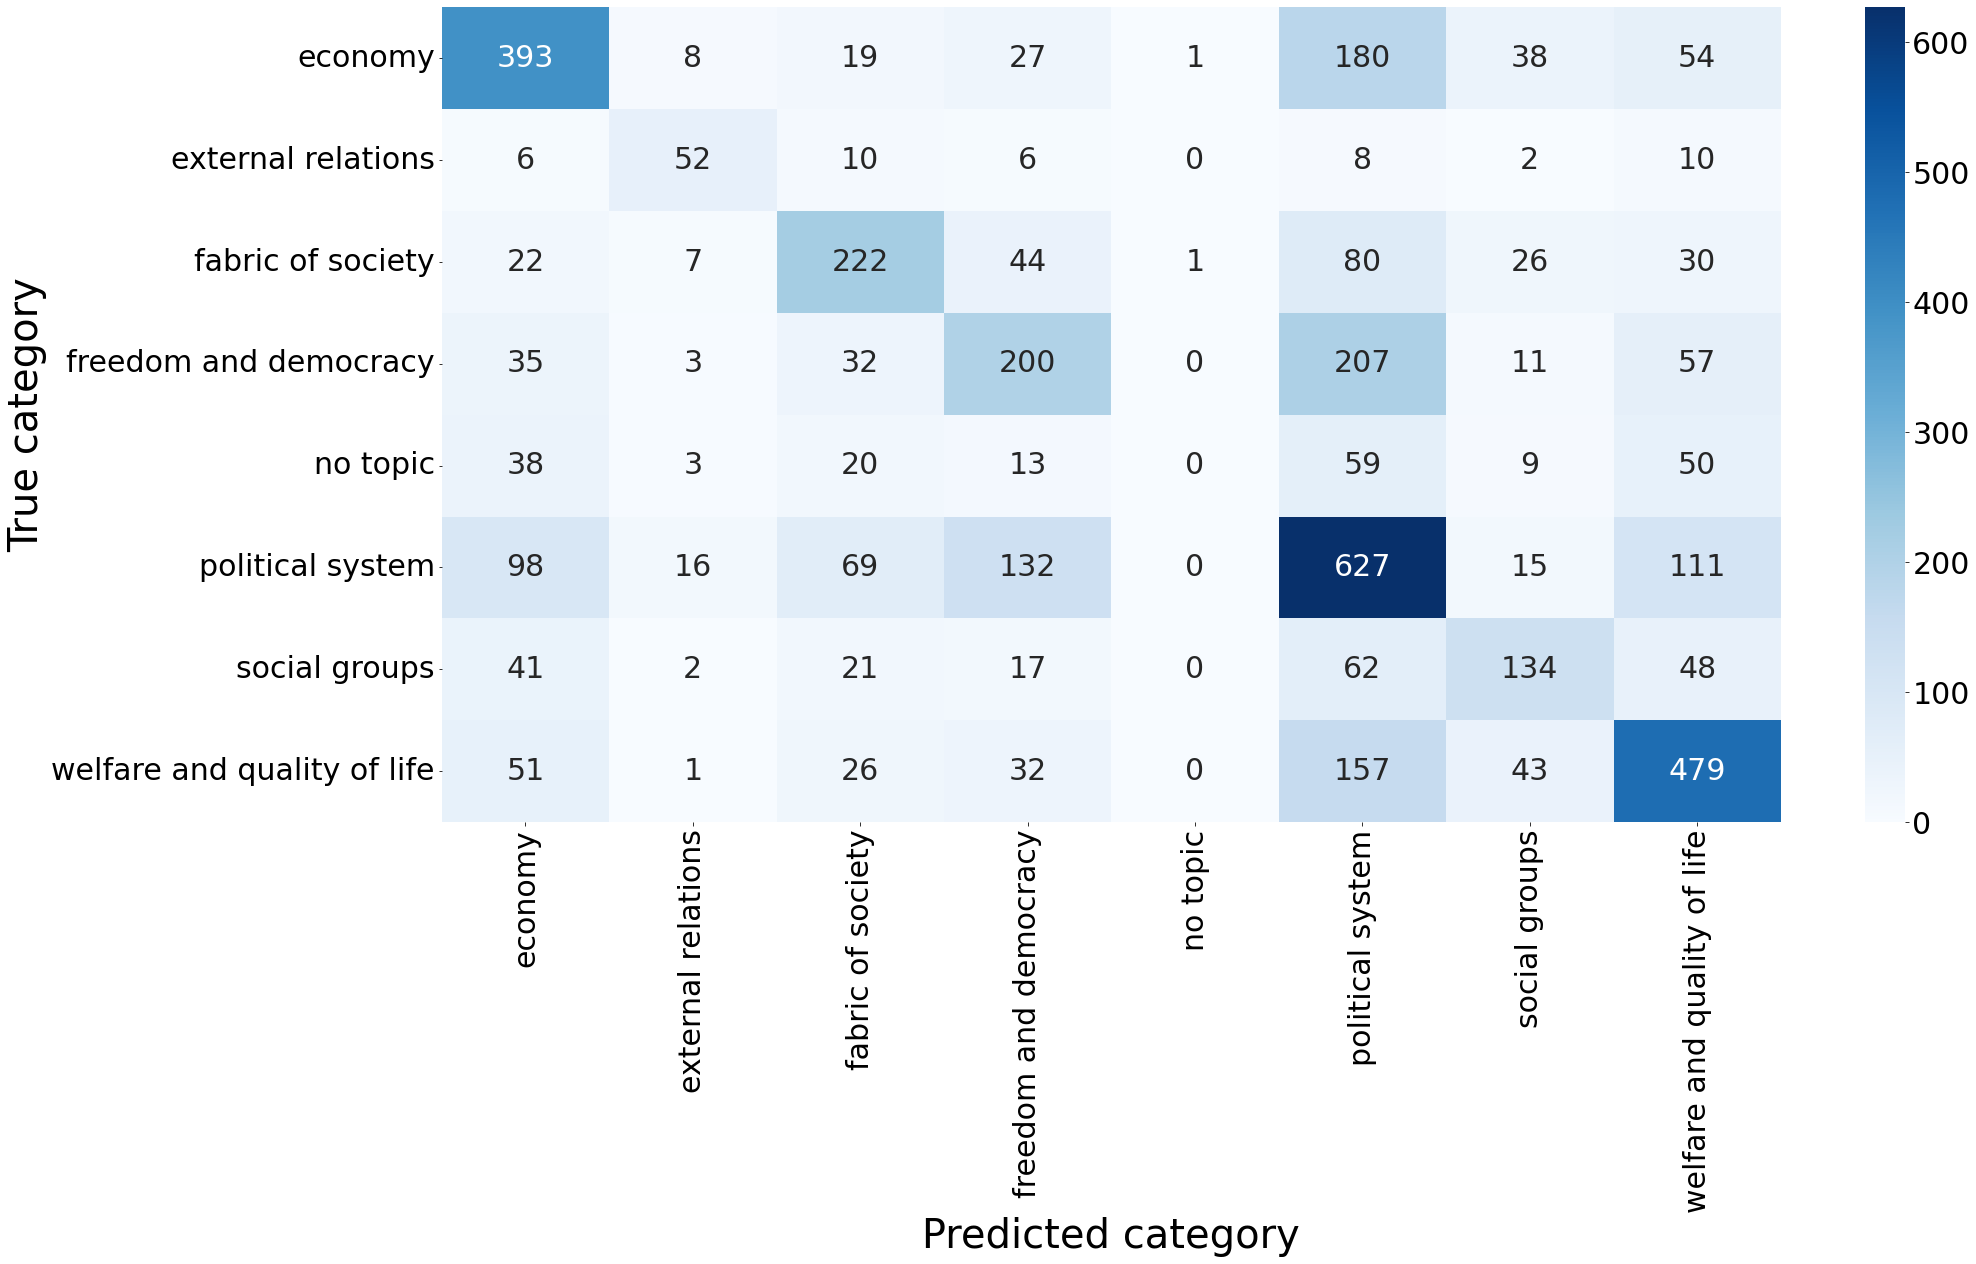

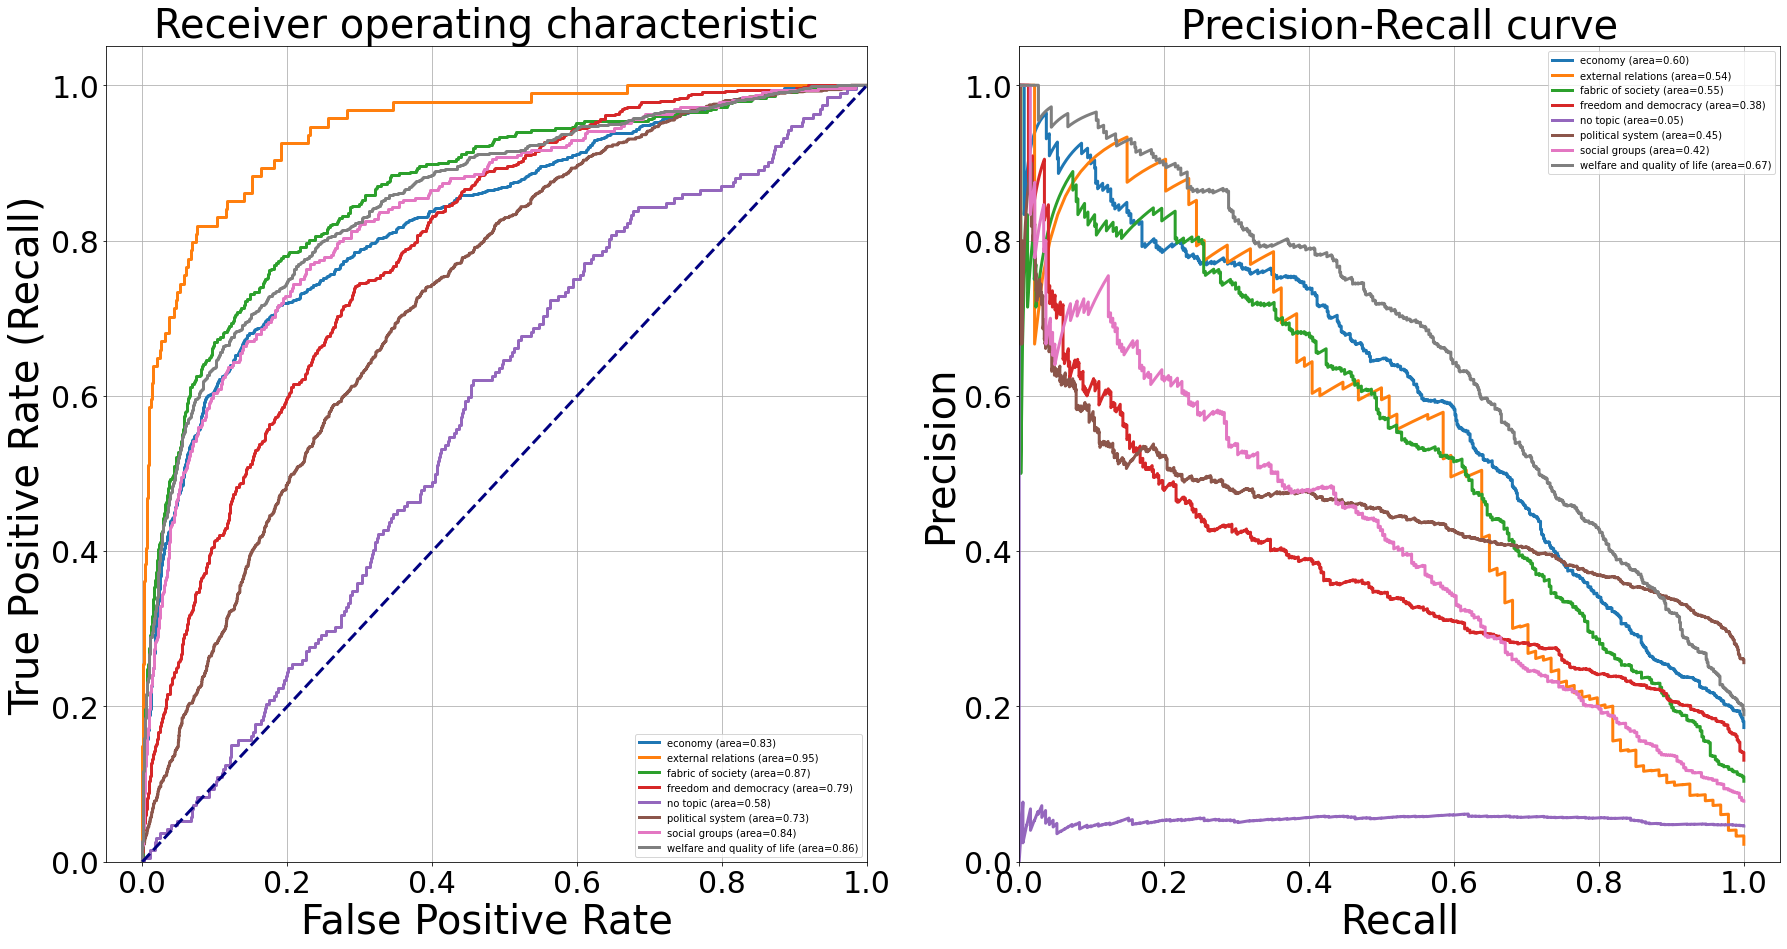

In [39]:
classification_report_target = evaluation_per_category(Y_target, Y_pred_target,  Y_prob_target, classes, data_description = "target", path_results = path_results)

## Overview and save resualts

In [41]:
eval_metrics = pd.concat([evaluation_table_training, evaluation_table_testing, evaluation_table_target])
eval_metrics.reset_index(drop = True, inplace = True)
eval_metrics.to_csv(path_results +'/eval_metrics.csv')
eval_metrics

,metric,score,domain,data
0,Accuracy,0.742507,within-domain,training
1,F1 score (macro),0.635382,within-domain,training
2,Accuracy,0.641301,within-domain,testing
3,F1 score (macro),0.519510,within-domain,testing
4,Accuracy,0.505882,cross-domain,target
5,F1 score (macro),0.447445,cross-domain,target


In [42]:
classification_report = pd.concat([classification_report_testing, classification_report_target])
classification_report.to_csv(path_results + '/classification_report.csv', index=True)
classification_report

,precision,recall,f1-score,support,data
economy,0.659794,0.747038,0.700711,5740.0,testing
external relations,0.705176,0.645604,0.674077,1456.0,testing
fabric of society,0.612111,0.557331,0.583438,2503.0,testing
freedom and democracy,0.583529,0.446043,0.505607,1112.0,testing
no topic,0.111111,0.005051,0.009662,198.0,testing
political system,0.519231,0.433277,0.472376,2368.0,testing
social groups,0.576878,0.429821,0.492608,2287.0,testing
welfare and quality of life,0.673531,0.767850,0.717605,7241.0,testing
economy,0.574561,0.545833,0.559829,720.0,target
external relations,0.565217,0.553191,0.559140,94.0,target


Packages:

In [43]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

pandas==1.4.4
numpy==1.22.4
seaborn==0.12.2


In [44]:
!pip list -v

Package                       Version              Location                               Installer
----------------------------- -------------------- -------------------------------------- ---------
absl-py                       1.4.0                /usr/local/lib/python3.9/dist-packages pip
alabaster                     0.7.13               /usr/local/lib/python3.9/dist-packages pip
albumentations                1.2.1                /usr/local/lib/python3.9/dist-packages pip
altair                        4.2.2                /usr/local/lib/python3.9/dist-packages pip
appdirs                       1.4.4                /usr/local/lib/python3.9/dist-packages pip
argon2-cffi                   21.3.0               /usr/local/lib/python3.9/dist-packages pip
argon2-cffi-bindings          21.2.0               /usr/local/lib/python3.9/dist-packages pip
arviz                         0.15.1               /usr/local/lib/python3.9/dist-packages pip
astropy                       5.2.1             